In [1]:
import cv2
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

from google_drive_downloader import GoogleDriveDownloader as gdd
import zipfile
from warnings import filterwarnings
from IPython.display import clear_output
filterwarnings("ignore")

In [2]:
!pip install pyyaml==5.1
!pip install gdown

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime
clear_output()

## Load data

In [3]:
from google.colab import files

In [4]:
# archive is here https://drive.google.com/file/d/1icBcLn3ZZzcUaOObd1cObmHV49X6_fE7/view?usp=sharing
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
!gdown https://drive.google.com/uc?id=1icBcLn3ZZzcUaOObd1cObmHV49X6_fE7
!unzip -qq data_object_detection

Downloading...
From: https://drive.google.com/uc?id=1icBcLn3ZZzcUaOObd1cObmHV49X6_fE7
To: /content/data_object_detection.zip
100% 652M/652M [00:05<00:00, 117MB/s]


In [6]:
# annotation
annotation_train = pd.read_csv("data_object_detection/Train.csv")
annotation_test = pd.read_csv("data_object_detection/Test.csv")
print(annotation_train.shape)
annotation_train.head()

(3906, 6)


,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [7]:
# classes distribution
annotation_train["class"].value_counts(normalize=True)

fruit_healthy      0.419355
fruit_woodiness    0.318996
fruit_brownspot    0.261649
Name: class, dtype: float64

In [8]:
# load images
train_path = glob("./data_object_detection/Train_Images/*.jpg")
train_path = np.random.choice(train_path, 5)
imgs = {}

for img_path in tqdm(train_path):
    temp = cv2.imread(img_path)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    img_name = img_path.split("\\")[-1].replace(".jpg", "")
    imgs[img_name] = temp
    assert temp.shape == (512, 512, 3)

  0%|          | 0/5 [00:00<?, ?it/s]

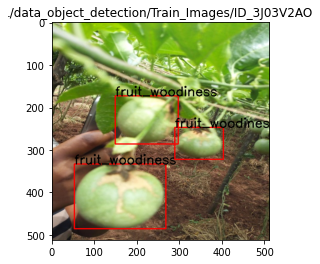

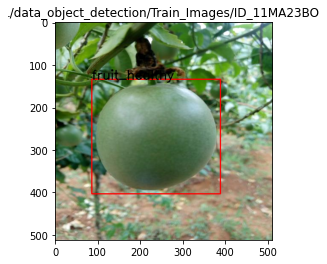

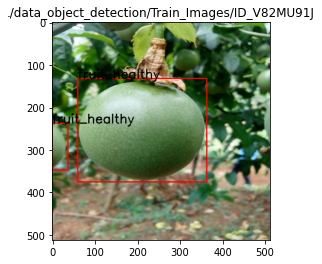

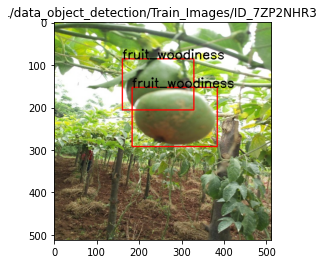

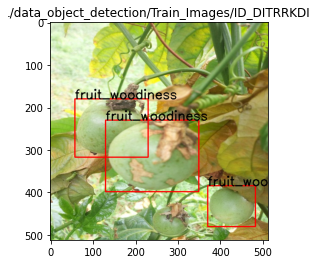

In [9]:
# draw boxes
for img_name in imgs:
    temp_img = imgs[img_name].copy()
    temp_annotation = annotation_train.loc[annotation_train['Image_ID']==img_name.split("/")[-1]]
    for _, row in temp_annotation.iterrows():
        xmin, ymin, width, height = row["xmin"], row["ymin"], row["width"], row["height"]
        xmax, ymax = xmin + width, ymin + height
        xmin, xmax, ymin, ymax = int(xmin), int(xmax), int(ymin), int(ymax)
        temp = cv2.rectangle(temp_img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
        temp_img = cv2.putText(temp_img, row["class"], (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    plt.imshow(temp_img)
    plt.title(img_name)
    plt.show()

## First try

Lets try some models from [Detectron2 Model Zoo](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md). I tested two metrics: Mean Average Precision and IOU.

In [10]:
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
import os

In [11]:
# class2idx
classes = annotation_train["class"].unique()
class2idx = dict(zip(classes, range(len(classes))))

def collect_dataset(dataset_path):
    # get dataset
    files = glob(dataset_path)
    dataset = []
    for img_id, img_path in tqdm(enumerate(files)):
        # metadata
        img_name = img_path.split("/")[-1].replace(".jpg", "")
        (img_height, img_width) = cv2.imread(img_path).shape[:-1]
        img_annotations = annotation_train.loc[annotation_train['Image_ID']==img_name]

        # bboxes
        objs = []
        for _, row in img_annotations.iterrows():
            xmin, ymin, width, height = row["xmin"], row["ymin"], row["width"], row["height"]
            xmax, ymax = xmin + width, ymin + height
            xmin, xmax, ymin, ymax = int(xmin), int(xmax), int(ymin), int(ymax)
            obj = {
                    "bbox": [xmin, ymin, xmax, ymax],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": class2idx[row["class"]],
                }
            objs.append(obj)

        # update dataset
        record = {"file_name":img_path,
                  "image_id":img_id,
                  "height":img_height,
                  "width":img_width,
                  "annotations":objs}
        dataset.append(record)
        
    return dataset

In [12]:
# collect datasets
dataset_path = "data_object_detection/Train_Images/*.jpg"
dataset_train = collect_dataset(dataset_path)
dataset_path = "data_object_detection/Test_Images/*.jpg"
dataset_test = collect_dataset(dataset_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [13]:
DatasetCatalog.clear()
MetadataCatalog.clear()

# register dataset
np.random.shuffle(dataset_train)
dataset_val = dataset_train[2500:]
dataset_train = dataset_train[:2500]

try:
    DatasetCatalog.register("dataset_train", lambda d="train": dataset_train)
    DatasetCatalog.register("dataset_val", lambda d="val": dataset_val)
    DatasetCatalog.register("dataset_test", lambda d="test": dataset_test)
    MetadataCatalog.get("dataset_train").set(thing_classes=list(classes))
    MetadataCatalog.get("dataset_val").set(thing_classes=list(classes))
    MetadataCatalog.get("dataset_test").set(thing_classes=list(classes))
except:
    pass

assert "dataset_train" in DatasetCatalog and "dataset_val" in DatasetCatalog and "dataset_test" in DatasetCatalog

metadata = MetadataCatalog.get("dataset_train")

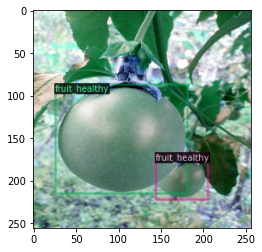

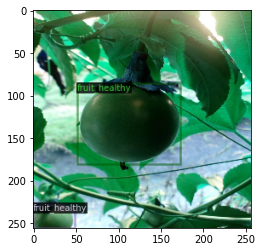

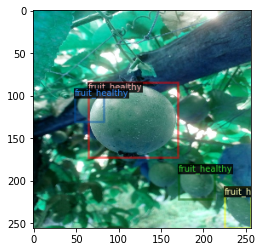

In [14]:
# viz again
for d in np.random.choice(dataset_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [15]:
%%time
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val",)
cfg.OUTPUT_DIR = "./data_object_detection/output"
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 1e-3
cfg.SOLVER.MAX_ITER = 600
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
clear_output()

CPU times: user 5.3 s, sys: 1.51 s, total: 6.81 s
Wall time: 18.7 s


In [16]:
%%time
# train
trainer.resume_or_load(resume=False)
trainer.train()

model_final_b275ba.pkl: 167MB [00:17, 9.47MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[11/22 03:46:30 d2.engine.train_loop]: Starting training from iteration 0
[11/22 03:46:49 d2.utils.events]:  eta: 0:09:02  iter: 19  total_loss: 2.437  loss_cls: 1.419  loss_box_reg: 1.029  loss_rpn_cls: 0.003745  loss_rpn_loc: 0.003087  time: 0.9016  data_time: 0.0196  lr: 3.2635e-05  max_mem: 1824M
[11/22 03:47:08 d2.utils.events]:  eta: 0:08:49  iter: 39  total_loss: 1.982  loss_cls: 1.01  loss_box_reg: 0.9489  loss_rpn_cls: 0.005191  loss_rpn_loc: 0.003765  time: 0.9238  data_time: 0.0076  lr: 6.5935e-05  max_mem: 1825M
[11/22 03:47:26 d2.utils.events]:  eta: 0:08:35  iter: 59  total_loss: 1.639  loss_cls: 0.6712  loss_box_reg: 0.996  loss_rpn_cls: 0.004141  loss_rpn_loc: 0.002348  time: 0.9315  data_time: 0.0079  lr: 9.9235e-05  max_mem: 1825M
[11/22 03:47:45 d2.utils.events]:  eta: 0:08:17  iter: 79  total_loss: 1.522  loss_cls: 0.5668  loss_box_reg: 0.9426  loss_rpn_cls: 0.0007307  loss_rpn_loc: 0.003251  time: 0.9318  data_time: 0.0081  lr: 0.00013253  max_mem: 1825M
[11/22 03:

In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

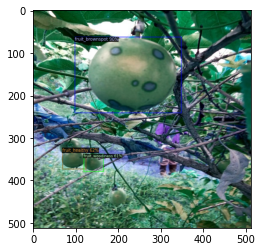

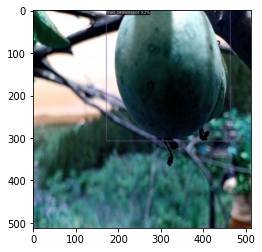

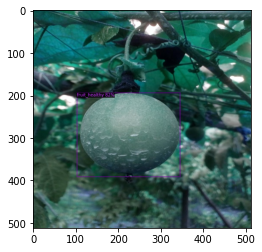

In [18]:
for d in np.random.choice(dataset_val, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [19]:
def calculate_scores():
    # Calculate scores
    scores = {class_name:{"tp":0, "fp":0, "iou":0, "count":0} for class_name in classes}

    for img_data in tqdm(dataset_val):
        # data
        img_name = img_data["file_name"].split("/")[-1].replace(".jpg", "")
        img_annotations = annotation_train.loc[annotation_train["Image_ID"]==img_name]
        img = cv2.imread(img_data["file_name"])
        img_pred = predictor(img)["instances"]
        
        # get true masks
        for _, row in img_annotations.iterrows():
            box_not_finded = True
            mask_true = np.zeros(img.shape)
            true_class = class2idx[row["class"]]
            scores[classes[true_class]]["count"] += 1
            xmin, ymin, width, height = row["xmin"], row["ymin"], row["width"], row["height"]
            xmax, ymax = xmin + width, ymin + height
            xmin, xmax, ymin, ymax = int(xmin), int(xmax), int(ymin), int(ymax)
            mask_true[xmin:xmax, ymin:ymax ] = 1

            # get pred mask
            pred_stats = img_pred.get_fields()
            for i in range(len(pred_stats["scores"])):
                mask_pred = np.zeros(img.shape)
                pred_score = pred_stats["scores"][i]
                pred_class = pred_stats["pred_classes"][i].cpu().item()
                pred_box = pred_stats["pred_boxes"][i].tensor.cpu().detach().numpy()[0]
                xmin, ymin, xmax, ymax = [int(i) for i in pred_box]
                mask_pred[xmin:xmax, ymin:ymax ] = 1
                
                # iou
                intersection = np.logical_and(mask_true, mask_pred)
                union = np.logical_or(mask_true, mask_pred)
                iou_score = np.sum(intersection) / np.sum(union)
                
                if iou_score > 0.5 and pred_score > 0.5:
                    if box_not_finded:
                        box_not_finded = False
                        scores[classes[true_class]]["iou"] += 1
                    if true_class == pred_class:
                        scores[classes[true_class]]["tp"] += 1
                    else:
                        scores[classes[true_class]]["fp"] += 1       
                        
    precsion_scores = {class_name:metrics["tp"] / (metrics["tp"] + metrics["fp"]) for class_name, metrics in scores.items()}
    iou_scores = {class_name: metrics["iou"] / metrics["count"] for class_name, metrics in scores.items()}
    print("Precision:")
    print(precsion_scores)
    print("IOU")
    print(iou_scores)
    print(f"MAP: {round(np.mean(list(precsion_scores.values())), 3)}, AverageIOU: {round(np.mean(list(iou_scores.values())), 3)}")

calculate_scores()

  0%|          | 0/501 [00:00<?, ?it/s]

Precision:
{'fruit_woodiness': 0.8326180257510729, 'fruit_brownspot': 0.8850574712643678, 'fruit_healthy': 0.9622641509433962}
IOU
{'fruit_woodiness': 0.9859154929577465, 'fruit_brownspot': 0.9819277108433735, 'fruit_healthy': 0.9735849056603774}
MAP: 0.893, AverageIOU: 0.98


In [21]:
def create_predict():
    # predict
    sample_submission = pd.read_csv("data_object_detection/Sample_submission.csv")[:0]

    for img_data in tqdm(dataset_test):
        img_missed =True
        # data
        img_name = img_data["file_name"].split("/")[-1].replace(".jpg", "")
        img = cv2.imread(img_data["file_name"])
        img_pred = predictor(img)["instances"]
        
        pred_stats = img_pred.get_fields()
        
        for i in range(len(pred_stats["scores"])):
            pred_score = pred_stats["scores"][i].cpu().item()
            pred_class = pred_stats["pred_classes"][i].cpu().item()
            pred_class = classes[pred_class]
            pred_box = pred_stats["pred_boxes"][i].tensor.cpu().detach().numpy()[0]
            xmin, ymin, xmax, ymax = [int(i) for i in pred_box]

            if pred_score > 0.5:
              img_missed = False
              sample_submission = sample_submission.append({"Image_ID":img_name, "class":pred_class, "confidence":pred_score,
                                                            "ymin":ymin, "xmin":xmin, "ymax":ymax, "xmax":xmax}, ignore_index=True)
              
        if img_missed:
            print(img_name)
            sample_submission = sample_submission.append({"Image_ID":img_name, "class":classes[0], "confidence":0,
                                                              "ymin":0, "xmin":0, "ymax":0, "xmax":0}, ignore_index=True)

    print(sample_submission.shape)
    sample_submission.to_csv("data_object_detection/Submission.csv", index=False)

# create_predict()

So, we have good IOU but our classification model works worse. Let's test bigger models

## Second try

In [22]:
%%time
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val",)
cfg.OUTPUT_DIR = "./data_object_detection/output"
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml") # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 1e-3
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
clear_output()

CPU times: user 3.34 s, sys: 302 ms, total: 3.65 s
Wall time: 3.64 s


In [23]:
%%time
# train
trainer.resume_or_load(resume=False)
trainer.train()

model_final_3e0943.pkl: 739MB [01:08, 10.8MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[11/22 04:00:31 d2.engine.train_loop]: Starting training from iteration 0
[11/22 04:01:08 d2.utils.events]:  eta: 0:14:57  iter: 19  total_loss: 2.127  loss_cls: 1.328  loss_box_reg: 0.7997  loss_rpn_cls: 0.007023  loss_rpn_loc: 0.01004  time: 1.8359  data_time: 0.0215  lr: 3.8962e-05  max_mem: 4531M
[11/22 04:01:46 d2.utils.events]:  eta: 0:14:24  iter: 39  total_loss: 1.646  loss_cls: 0.7561  loss_box_reg: 0.8756  loss_rpn_cls: 0.007851  loss_rpn_loc: 0.01017  time: 1.8699  data_time: 0.0094  lr: 7.8922e-05  max_mem: 4531M
[11/22 04:02:24 d2.utils.events]:  eta: 0:13:49  iter: 59  total_loss: 1.352  loss_cls: 0.5353  loss_box_reg: 0.835  loss_rpn_cls: 0.007423  loss_rpn_loc: 0.01103  time: 1.8801  data_time: 0.0076  lr: 0.00011888  max_mem: 4531M
[11/22 04:03:01 d2.utils.events]:  eta: 0:13:12  iter: 79  total_loss: 1.279  loss_cls: 0.4238  loss_box_reg: 0.8267  loss_rpn_cls: 0.002651  loss_rpn_loc: 0.01016  time: 1.8740  data_time: 0.0112  lr: 0.00015884  max_mem: 4531M
[11/22 04:03

In [24]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [25]:
calculate_scores()
# create_predict()

  0%|          | 0/501 [00:00<?, ?it/s]

Precision:
{'fruit_woodiness': 0.7372881355932204, 'fruit_brownspot': 0.7945945945945946, 'fruit_healthy': 0.9809160305343512}
IOU
{'fruit_woodiness': 0.9624413145539906, 'fruit_brownspot': 0.9759036144578314, 'fruit_healthy': 0.9811320754716981}
MAP: 0.838, AverageIOU: 0.973


## Third try

In [26]:
%%time
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val",)
cfg.OUTPUT_DIR = "./data_object_detection/output"
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml") # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 1e-3
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
clear_output()

CPU times: user 1.35 s, sys: 39 ms, total: 1.38 s
Wall time: 1.39 s


In [27]:
%%time
# train
trainer.resume_or_load(resume=False)
trainer.train()

model_final_f6e8b1.pkl: 243MB [00:45, 5.38MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[11/22 04:23:06 d2.engine.train_loop]: Starting training from iteration 0
[11/22 04:23:34 d2.utils.events]:  eta: 0:10:58  iter: 19  total_loss: 2.388  loss_cls: 1.386  loss_box_reg: 0.9832  loss_rpn_cls: 0.003451  loss_rpn_loc: 0.003317  time: 1.3480  data_time: 0.0187  lr: 3.8962e-05  max_mem: 4531M
[11/22 04:24:00 d2.utils.events]:  eta: 0:10:28  iter: 39  total_loss: 1.823  loss_cls: 0.8109  loss_box_reg: 0.9371  loss_rpn_cls: 0.001609  loss_rpn_loc: 0.003386  time: 1.3419  data_time: 0.0091  lr: 7.8922e-05  max_mem: 4531M
[11/22 04:24:27 d2.utils.events]:  eta: 0:09:55  iter: 59  total_loss: 1.575  loss_cls: 0.6286  loss_box_reg: 0.9583  loss_rpn_cls: 0.001097  loss_rpn_loc: 0.002649  time: 1.3319  data_time: 0.0064  lr: 0.00011888  max_mem: 4531M
[11/22 04:24:53 d2.utils.events]:  eta: 0:09:28  iter: 79  total_loss: 1.457  loss_cls: 0.4872  loss_box_reg: 0.9555  loss_rpn_cls: 0.0009708  loss_rpn_loc: 0.002801  time: 1.3288  data_time: 0.0081  lr: 0.00015884  max_mem: 4531M
[11/22

In [28]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [29]:
calculate_scores()
# create_predict()

  0%|          | 0/501 [00:00<?, ?it/s]

Precision:
{'fruit_woodiness': 0.4260869565217391, 'fruit_brownspot': 0.8388888888888889, 'fruit_healthy': 0.9961389961389961}
IOU
{'fruit_woodiness': 0.9577464788732394, 'fruit_brownspot': 0.9879518072289156, 'fruit_healthy': 0.9773584905660377}
MAP: 0.754, AverageIOU: 0.974


## Pretrained Classifier (ResNet)

So, we have good IOU but really bad MAP. Lets try to replace classification part to ResNet

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [31]:
# load images
train_path = glob("./data_object_detection/Train_Images/*.jpg")
imgs = {}

for img_path in tqdm(train_path):
    temp = cv2.imread(img_path)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    img_name = img_path.split("\\")[-1].replace(".jpg", "")
    imgs[img_name] = temp
    assert temp.shape == (512, 512, 3)

  0%|          | 0/3001 [00:00<?, ?it/s]

In [32]:
# collect boxes
dataset, labels = [], []

for img_name in tqdm(imgs):
    temp_img = imgs[img_name].copy()
    temp_annotation = annotation_train.loc[annotation_train['Image_ID']==img_name.split("/")[-1]]
    for _, row in temp_annotation.iterrows():
        xmin, ymin, width, height = row["xmin"], row["ymin"], row["width"], row["height"]
        xmax, ymax = xmin + width, ymin + height
        xmin, xmax, ymin, ymax = int(xmin), int(xmax), int(ymin), int(ymax)
        dataset.append(cv2.resize(temp_img[ymin:ymax, xmin:xmax], (200, 200)))
        labels.append(class2idx[row["class"]])

assert len(dataset) == len(labels)
dataset, labels = np.array(dataset), np.array(labels)

  0%|          | 0/3001 [00:00<?, ?it/s]

In [33]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test, labels_train, labels_test = train_test_split(dataset, labels, test_size=0.2)
dataset_train.shape, dataset_test.shape

((3124, 200, 200, 3), (782, 200, 200, 3))

In [34]:
%%time
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_train, labels_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dataset_test, labels_test))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

CPU times: user 254 ms, sys: 243 ms, total: 498 ms
Wall time: 1.04 s


In [35]:
def get_model():
    # load pretrained model
    pretrained = keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=None,
                                             input_shape=(200, 200, 3))
    pretrained.trainable = False
    # add trainable head
    inputs = layers.Input(shape=(200, 200, 3))
    x = pretrained(inputs, training=False)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(3)(x)
    
    return keras.Model(inputs, output)

In [36]:
#model
classifier = get_model()
# compile
classifier.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# train
epochs=5
history = classifier.fit(train_dataset, validation_data=test_dataset, epochs=epochs) 

94781440/94765736 [==============================] - 2s 0us/step
Epoch 1/5
49/49 [==============================] - 59s 522ms/step - loss: 3.1916 - accuracy: 0.8227 - val_loss: 0.5629 - val_accuracy: 0.9054
Epoch 2/5
49/49 [==============================] - 22s 459ms/step - loss: 0.1484 - accuracy: 0.9661 - val_loss: 0.2289 - val_accuracy: 0.9668
Epoch 3/5
49/49 [==============================] - 22s 459ms/step - loss: 0.0214 - accuracy: 0.9917 - val_loss: 0.1817 - val_accuracy: 0.9616
Epoch 4/5
49/49 [==============================] - 22s 460ms/step - loss: 0.0101 - accuracy: 0.9962 - val_loss: 0.2333 - val_accuracy: 0.9693
Epoch 5/5
49/49 [==============================] - 22s 459ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.2394 - val_accuracy: 0.9655


In [37]:
def calculate_scores():
    # Calculate scores
    scores = {class_name:{"tp":0, "fp":0, "iou":0, "count":0} for class_name in classes}

    for img_data in tqdm(dataset_val):
        # data
        img_name = img_data["file_name"].split("/")[-1].replace(".jpg", "")
        img_annotations = annotation_train.loc[annotation_train["Image_ID"]==img_name]
        img = cv2.imread(img_data["file_name"])
        img_pred = predictor(img)["instances"]
        
        # get true masks
        for _, row in img_annotations.iterrows():
            box_not_finded = True
            mask_true = np.zeros(img.shape)
            true_class = class2idx[row["class"]]
            scores[classes[true_class]]["count"] += 1
            xmin, ymin, width, height = row["xmin"], row["ymin"], row["width"], row["height"]
            xmax, ymax = xmin + width, ymin + height
            xmin, xmax, ymin, ymax = int(xmin), int(xmax), int(ymin), int(ymax)
            mask_true[xmin:xmax, ymin:ymax ] = 1

            # get pred mask
            pred_stats = img_pred.get_fields()
            for i in range(len(pred_stats["scores"])):
                mask_pred = np.zeros(img.shape)
                pred_score = pred_stats["scores"][i]
                pred_box = pred_stats["pred_boxes"][i].tensor.cpu().detach().numpy()[0]
                xmin, ymin, xmax, ymax = [int(i) for i in pred_box]
                mask_pred[xmin:xmax, ymin:ymax ] = 1

                # classifier
                img_resize = cv2.resize(img[ymin:ymax, xmin:xmax], (200, 200))
                img_resize = np.expand_dims(img_resize, axis=0)
                pred_class = layers.Softmax()(classifier(img_resize))
                pred_class = tf.argmax(pred_class, axis=1).cpu().numpy()[0]
                
                # iou
                intersection = np.logical_and(mask_true, mask_pred)
                union = np.logical_or(mask_true, mask_pred)
                iou_score = np.sum(intersection) / np.sum(union)
                
                if iou_score > 0.5 and pred_score > 0.5:
                    if box_not_finded:
                        box_not_finded = False
                        scores[classes[true_class]]["iou"] += 1
                    if true_class == pred_class:
                        scores[classes[true_class]]["tp"] += 1
                    else:
                        scores[classes[true_class]]["fp"] += 1       
                        
    precsion_scores = {class_name:metrics["tp"] / (metrics["tp"] + metrics["fp"]) for class_name, metrics in scores.items()}
    iou_scores = {class_name: metrics["iou"] / metrics["count"] for class_name, metrics in scores.items()}
    print("Precision:")
    print(precsion_scores)
    print("IOU")
    print(iou_scores)
    print(f"MAP: {round(np.mean(list(precsion_scores.values())), 3)}, AverageIOU: {round(np.mean(list(iou_scores.values())), 3)}")

In [38]:
calculate_scores()

  0%|          | 0/501 [00:00<?, ?it/s]

Instructions for updating:
Use tf.identity instead.
Precision:
{'fruit_woodiness': 0.9565217391304348, 'fruit_brownspot': 0.8944444444444445, 'fruit_healthy': 0.9884169884169884}
IOU
{'fruit_woodiness': 0.9577464788732394, 'fruit_brownspot': 0.9879518072289156, 'fruit_healthy': 0.9773584905660377}
MAP: 0.946, AverageIOU: 0.974


### Train Final Model

ResNet50 clasifier works better, lets train final model and try to submit

In [39]:
# collect datasets
dataset_path = "data_object_detection/Train_Images/*.jpg"
dataset_train = collect_dataset(dataset_path)
dataset_path = "data_object_detection/Test_Images/*.jpg"
dataset_test = collect_dataset(dataset_path)

DatasetCatalog.clear()
MetadataCatalog.clear()

try:
    DatasetCatalog.register("dataset_train", lambda d="train": dataset_train)
    DatasetCatalog.register("dataset_test", lambda d="test": dataset_test)
    MetadataCatalog.get("dataset_train").set(thing_classes=list(classes))
    MetadataCatalog.get("dataset_test").set(thing_classes=list(classes))
except:
    pass

assert "dataset_train" in DatasetCatalog and "dataset_test" in DatasetCatalog

metadata = MetadataCatalog.get("dataset_train")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [40]:
%%time
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ()
cfg.OUTPUT_DIR = "./data_object_detection/output"
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml") # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 1e-3
cfg.SOLVER.MAX_ITER = 600
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
clear_output()

CPU times: user 1.4 s, sys: 44.2 ms, total: 1.45 s
Wall time: 1.44 s


In [41]:
 %%time
# train
trainer.resume_or_load(resume=False)
trainer.train()

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[11/22 04:48:49 d2.engine.train_loop]: Starting training from iteration 0
[11/22 04:49:18 d2.utils.events]:  eta: 0:14:45  iter: 19  total_loss: 2.11  loss_cls: 1.168  loss_box_reg: 0.9099  loss_rpn_cls: 0.002473  loss_rpn_loc: 0.004594  time: 1.4582  data_time: 0.0266  lr: 3.2635e-05  max_mem: 4531M
[11/22 04:49:46 d2.utils.events]:  eta: 0:13:29  iter: 39  total_loss: 1.786  loss_cls: 0.7818  loss_box_reg: 0.9863  loss_rpn_cls: 0.001906  loss_rpn_loc: 0.002749  time: 1.4167  data_time: 0.0074  lr: 6.5935e-05  max_mem: 4531M
[11/22 04:50:14 d2.utils.events]:  eta: 0:12:49  iter: 59  total_loss: 1.546  loss_cls: 0.5947  loss_box_reg: 0.9487  loss_rpn_cls: 0.002084  loss_rpn_loc: 0.002656  time: 1.4044  data_time: 0.0074  lr: 9.9235e-05  max_mem: 4531M
[11/22 04:50:41 d2.utils.events]:  eta: 0:12:20  iter: 79  total_loss: 1.454  loss_cls: 0.5038  loss_box_reg: 0.9398  loss_rpn_cls: 0.001041  loss_rpn_loc: 0.002504  time: 1.3969  data_time: 0.0089  lr: 0.00013253  max_mem: 4531M
[11/22 0

KeyboardInterrupt: ignored

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
%%time
classification_dataset = tf.data.Dataset.from_tensor_slices((dataset, labels))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

classification_dataset = classification_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

#model
classifier = get_model()
# compile
classifier.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# train
epochs=5
history = classifier.fit(classification_dataset, epochs=epochs) 

In [ ]:
def create_predict():
    # predict
    sample_submission = pd.read_csv("data_object_detection/Sample_submission.csv")[:0]

    for img_data in tqdm(dataset_test):
        img_missed =True
        # data
        img_name = img_data["file_name"].split("/")[-1].replace(".jpg", "")
        img = cv2.imread(img_data["file_name"])
        img_pred = predictor(img)["instances"]
        
        pred_stats = img_pred.get_fields()
        
        for i in range(len(pred_stats["scores"])):
            pred_score = pred_stats["scores"][i].cpu().item()   
            pred_box = pred_stats["pred_boxes"][i].tensor.cpu().detach().numpy()[0]
            xmin, ymin, xmax, ymax = [int(i) for i in pred_box]

            # classifier
            img_resize = cv2.resize(img[ymin:ymax, xmin:xmax], (200, 200))
            img_resize = np.expand_dims(img_resize, axis=0)
            pred_class = layers.Softmax()(classifier(img_resize))
            pred_class = tf.argmax(pred_class, axis=1).cpu().numpy()[0]
            pred_class = classes[pred_class]

            if pred_score > 0.5:
              img_missed = False
              sample_submission = sample_submission.append({"Image_ID":img_name, "class":pred_class, "confidence":pred_score,
                                                            "ymin":ymin, "xmin":xmin, "ymax":ymax, "xmax":xmax}, ignore_index=True)
              
        if img_missed:
            print(img_name)
            sample_submission = sample_submission.append({"Image_ID":img_name, "class":classes[0], "confidence":0,
                                                              "ymin":0, "xmin":0, "ymax":0, "xmax":0}, ignore_index=True)

    print(sample_submission.shape)
    sample_submission.to_csv("data_object_detection/Submission.csv", index=False)

In [ ]:
create_predict()

|Model|MAP|IOU|
|-----|---|---|
|faster_rcnn_R_50_FPN_1x|0.893|0.98|
|faster_rcnn_R_101_DC5_3x|0.838|0.973|
|faster_rcnn_R_101_FPN_3x|0.754|0.974|
|ResNet Classifier|0.946|0.974|